In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from pathlib import Path
from gluonts.dataset.common import load_datasets
from time_grad_estimator import TimeGradEstimator
from trainer import Trainer
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 1
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 6))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color='r', ls="-", label=f"{label_prefix}median", ax=ax)
        
        if dim==0:
            df = pd.DataFrame(p50_data)
            # 将 DataFrame 写入 Excel 文件
            output_file = 'calce_best/calce1.xlsx'  # 输出文件名
            df.to_excel(output_file, index=False, engine='openpyxl')  # index=False 表示不写入行索引

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color='y',
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)
    else:
        print("n")

In [3]:
from pathlib import Path
from gluonts.dataset.common import load_datasets
data_dir = r'/home/lab106-dell/sss/timegrad-master'    #保存creat的上一个目录
data_dir = Path(data_dir)
dataset = load_datasets(
    metadata=data_dir / "calce",
    train=data_dir / "calce" / "train",
    test=data_dir / "calce" / "test",
)
features = [i for i in list(dir(dataset)) if not i.startswith("_")]
display(features)

['count', 'index', 'metadata', 'save', 'test', 'train']

In [4]:
# train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

# test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
#                                    max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

train_grouper = MultivariateGrouper(max_target_dim=16)
test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=16)
print(len(dataset.train))
print(len(dataset.test))

3
3


In [5]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-package

In [6]:
for group1 in dataset_train:
    print(group1)

for group2 in dataset_test:
    print(group2)

{'target': array([[1.1263845e+00, 1.1261598e+00, 1.1259657e+00, ..., 3.9420000e-01,
        3.9419103e-01, 3.9418325e-01],
       [8.2517499e-01, 8.1596512e-01, 8.1597698e-01, ..., 1.6502288e-01,
        1.6500936e-01, 1.7418005e-01],
       [6.6130591e+03, 6.6124028e+03, 6.6085605e+03, ..., 1.5945042e+03,
        1.5606610e+03, 1.5300833e+03]], dtype=float32), 'start': Timestamp('2023-01-01 00:00:00', freq='D'), 'feat_static_cat': array([0], dtype=int32), 'source': SourceContext(source='list_data', row=0)}
{'target': array([[1.12638450e+00, 1.12615979e+00, 1.12596571e+00, ...,
        3.02529901e-01, 3.02530378e-01, 2.93367475e-01],
       [8.25174987e-01, 8.15965116e-01, 8.15976977e-01, ...,
        1.00843027e-01, 1.10013694e-01, 1.00846060e-01],
       [6.61305908e+03, 6.61240283e+03, 6.60856055e+03, ...,
        1.01420154e+03, 1.02365424e+03, 1.03634180e+03]], dtype=float32), 'start': Timestamp('2023-01-01 00:00:00', freq='D'), 'feat_static_cat': array([0], dtype=int32), 'source'

In [7]:
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# 假设 group1['target'] 是一个形状为 (5, 874) 的 NumPy 数组

# 提取主特征（第 0 维）
main_feature = group1['target'][0, :]

# 存储每个维度的 DTW 距离
dtw_distances = []

# 添加归一化函数
def normalize(series):
    """
    将序列归一化到 [0, 1] 区间。
    """
    return (series - np.min(series)) / (np.max(series) - np.min(series))
def custom_euclidean(u, v):
    return np.sqrt(np.sum((u - v) ** 2))

# 对主特征进行归一化
main_feature_normalized = normalize(main_feature)

# 计算第 1 到第 4 维与主特征的 DTW 距离
for i in range(1, group1['target'].shape[0]):
    other_feature = group1['target'][i, :]
    # distance, _ = fastdtw(main_feature, other_feature, dist=euclidean)
    # 对其他特征进行归一化
    other_feature_normalized = normalize(other_feature)
    distance, path = fastdtw(main_feature_normalized, other_feature_normalized, dist=custom_euclidean)
    # distance, path = fastdtw(main_feature, other_feature, dist=custom_euclidean)
    dtw_distances.append((i, distance))  # 存储维度索引和对应的距离

# 输出结果
for i, distance in dtw_distances:
    print(f"DTW 距离: 主特征(0) 与特征({i}) = {distance}")


DTW 距离: 主特征(0) 与特征(1) = 7.869265619472515
DTW 距离: 主特征(0) 与特征(2) = 17.24730592210915


In [8]:
print(group1['target'].shape)
print(group2['target'].shape)

(3, 815)
(3, 847)


D


  0%|          | 0/99 [00:00<?, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts

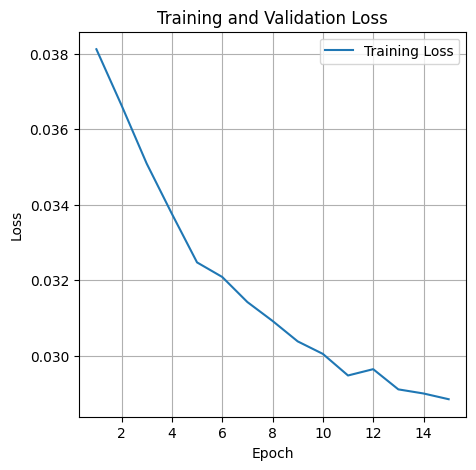

In [9]:
estimator = TimeGradEstimator(
    target_dim=3,
    conditioning_length=16,
    prediction_length=32,
    context_length=16,
    cell_type='LSTM',   #GRU
    input_size=11,
    freq="D",          
    loss_type='l2',
    scaling=True,
    diff_steps=40,
    beta_end=0.04,  #添加噪声强度
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=30,
                    learning_rate=7e-6,
                    num_batches_per_epoch=100,
                    batch_size=128,),
    series=group2['target'],
)
predictor = estimator.train(dataset_train, num_workers=10)

/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


n


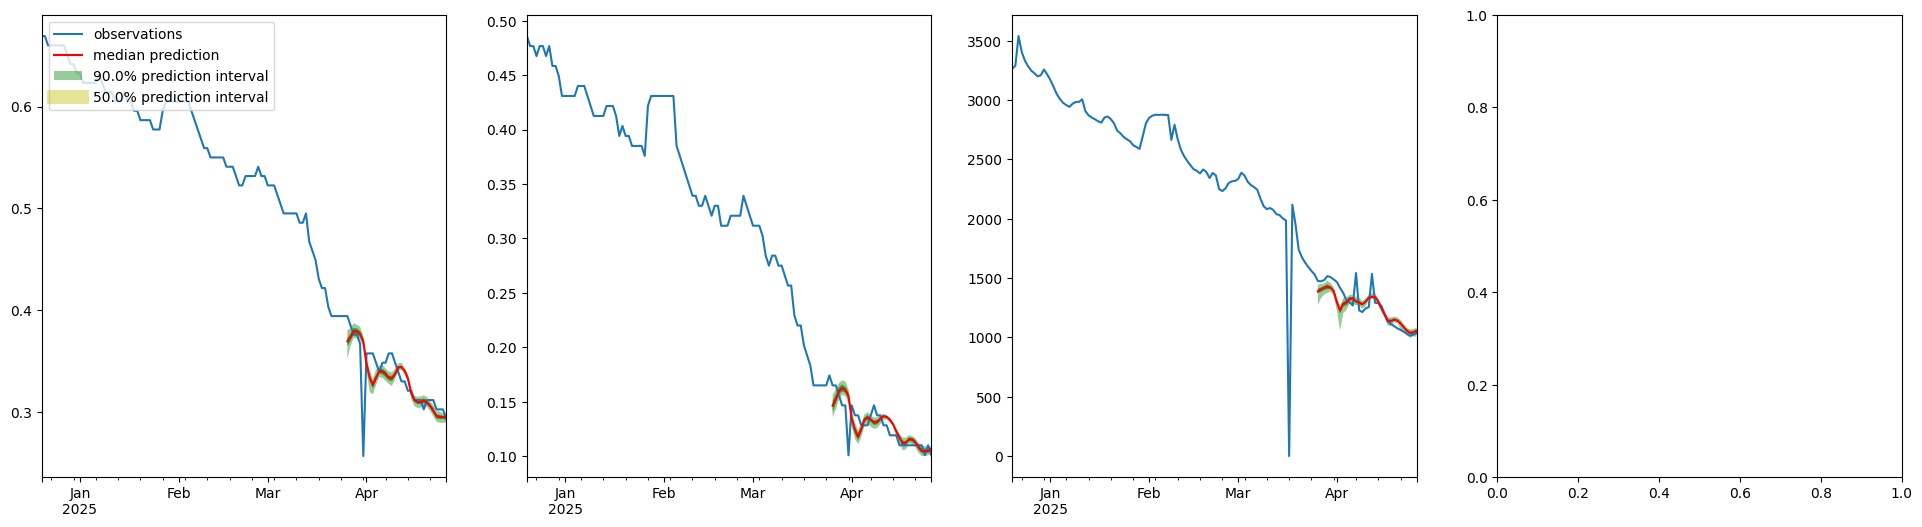

Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 108.48it/s]
Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 134.35it/s]
Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 142.12i

MAPE: 0.05599030355612437
MSE: 3319.9289587647654
CRPS: 0.04715446849102788


In [10]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=64,
)
plt.show()

evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

print("MAPE:", agg_metric["MAPE"])
print("MSE:", agg_metric["MSE"])
print("CRPS:", agg_metric["mean_wQuantileLoss"])


In [19]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 69.45it/s]
Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 72.77it/s]
Running evaluation: 0it [00:00, ?it/s]/home/lab106-dell/.conda/envs/sss-time/lib/python3.9/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 1it [00:00, 72.58it/s

In [39]:
for key, value in agg_metric.items():
    print(f"{key}: {value}")


0_MSE: 0.00022156399791128933
0_abs_error: 0.4318888485431671
0_abs_target_sum: 11.448932647705078
0_abs_target_mean: 0.3577791452407837
0_seasonal_error: 0.00469313403801136
0_MASE: 2.875802482447935
0_MAPE: 0.038048986345529556
0_sMAPE: 0.03721097856760025
0_MSIS: 44.994538116532595
0_QuantileLoss[0.05]: 0.3798283159732818
0_Coverage[0.05]: 0.6875
0_QuantileLoss[0.1]: 0.44767035245895387
0_Coverage[0.1]: 0.78125
0_QuantileLoss[0.15]: 0.4852202653884887
0_Coverage[0.15]: 0.78125
0_QuantileLoss[0.2]: 0.5010472297668458
0_Coverage[0.2]: 0.78125
0_QuantileLoss[0.25]: 0.5085043609142303
0_Coverage[0.25]: 0.8125
0_QuantileLoss[0.3]: 0.5033790111541747
0_Coverage[0.3]: 0.8125
0_QuantileLoss[0.35]: 0.49066467285156246
0_Coverage[0.35]: 0.84375
0_QuantileLoss[0.4]: 0.47450711727142336
0_Coverage[0.4]: 0.875
0_QuantileLoss[0.45]: 0.4540584236383438
0_Coverage[0.45]: 0.875
0_QuantileLoss[0.5]: 0.4318888485431671
0_Coverage[0.5]: 0.90625
0_QuantileLoss[0.55]: 0.4025428295135498
0_Coverage[0.55]:

In [40]:
print("0_MSE:", agg_metric["0_MSE"])
print("0_MAPE:", agg_metric["0_MAPE"])
print("0_mean_wQuantileLoss:", agg_metric["0_mean_wQuantileLoss"])
# print("")
# print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
# print("ND-Sum:", agg_metric["m_sum_ND"])
# print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

0_MSE: 0.00022156399791128933
0_MAPE: 0.038048986345529556
0_mean_wQuantileLoss: 0.032125134478203435


In [ ]:
print("MAPE:", agg_metric["MAPE"])
print("MSE:", agg_metric["MSE"])
